In [2]:
from clickhouse_driver import Client

In [6]:
database = 'metro'
table = 'station'
# Подключение к ClickHouse
client = Client(host='localhost', database=database)

# Создание базы данных
client.execute('CREATE DATABASE IF NOT EXISTS metro')

# Создание таблицы
client.execute('''
CREATE TABLE IF NOT EXISTS metro.station (
    C_A String,
    Unit String,
    SCP String,
    Station String,
    Date Date,
    Time String,
    Description String,
    Entries Int64,
    Exits Int64,
    datetime DateTime,
    turnstile String
) ENGINE = MergeTree()
ORDER BY (Station, datetime)
''')



query = f'''
SELECT count(*) 
FROM system.tables 
WHERE database = '{database}' AND name = '{table}'
'''

# Выполнение запроса
table_exists = client.execute(query)[0][0]

# Вывод результата
if table_exists:
    print(f"Таблица {table} существует в базе данных {database}.")
else:
    print(f"Таблица {table} не существует в базе данных {database}.")

Таблица station существует в базе данных metro.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.ticker import FuncFormatter
matplotlib.style.use('ggplot')
import sqlite3 
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

mta = pd.read_csv('Turnstile_Usage_Data__2022.csv', sep = ',',header = None)

# Присвоение имен столбцов
mta.columns = ['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date', 'Time', 'Description', 'Entries', 'Exits']

# mta.columns =['C/A','unit','SCP','Station','date','time','desc','entries','exits']

# Оставляем только нужные столбцы
mta = mta[['C/A', 'Unit', 'SCP', 'Station', 'Date', 'Time', 'Description', 'Entries', 'Exits']]
mta = mta.drop(index=0)
print(mta.head())

    C/A  Unit       SCP Station        Date      Time Description  Entries  \
1  A002  R051  02-00-00   59 ST  01/01/2022  03:00:00     REGULAR  7675872   
2  A002  R051  02-00-00   59 ST  01/01/2022  07:00:00     REGULAR  7675876   
3  A002  R051  02-00-00   59 ST  01/01/2022  11:00:00     REGULAR  7675887   
4  A002  R051  02-00-00   59 ST  01/01/2022  15:00:00     REGULAR  7675895   
5  A002  R051  02-00-00   59 ST  01/01/2022  19:00:00     REGULAR  7675920   

     Exits  
1  2649548  
2  2649551  
3  2649594  
4  2649626  
5  2649657  


In [5]:
mta['datetime'] = pd.to_datetime(mta.Date + ' ' + mta.Time, format='%m/%d/%Y  %H:%M:%S')
mta['turnstile'] = mta['C/A'] + '-' + mta['Unit'] + '-' + mta['SCP']

mta = mta[(mta.datetime >= '01-01-18 00:00:00') & 
          (mta.datetime <'07-01-26 00:00:00')]

print(mta.head())

    C/A  Unit       SCP Station        Date      Time Description  Entries  \
1  A002  R051  02-00-00   59 ST  01/01/2022  03:00:00     REGULAR  7675872   
2  A002  R051  02-00-00   59 ST  01/01/2022  07:00:00     REGULAR  7675876   
3  A002  R051  02-00-00   59 ST  01/01/2022  11:00:00     REGULAR  7675887   
4  A002  R051  02-00-00   59 ST  01/01/2022  15:00:00     REGULAR  7675895   
5  A002  R051  02-00-00   59 ST  01/01/2022  19:00:00     REGULAR  7675920   

     Exits            datetime           turnstile  
1  2649548 2022-01-01 03:00:00  A002-R051-02-00-00  
2  2649551 2022-01-01 07:00:00  A002-R051-02-00-00  
3  2649594 2022-01-01 11:00:00  A002-R051-02-00-00  
4  2649626 2022-01-01 15:00:00  A002-R051-02-00-00  
5  2649657 2022-01-01 19:00:00  A002-R051-02-00-00  


In [14]:
print(mta.head())

# Преобразование строк в даты
mta['Date'] = pd.to_datetime(mta['Date'], infer_datetime_format=True, dayfirst=False).dt.date
mta['datetime'] = pd.to_datetime(mta['datetime'], infer_datetime_format=True, dayfirst=False)

# Преобразование строк в целые числа
mta['Entries'] = pd.to_numeric(mta['Entries'], errors='coerce').fillna(0).astype(int)
mta['Exits'] = pd.to_numeric(mta['Exits'], errors='coerce').fillna(0).astype(int)

# Преобразование данных в список кортежей
data = list(mta.itertuples(index=False, name=None))

# Вставка данных в таблицу с обработкой исключений
try:
    client.execute('''
    INSERT INTO metro.station (C_A,
    Unit ,
    SCP ,
    Station ,
    Date ,
    Time ,
    Description ,
    Entries ,
    Exits ,
    datetime ,
    turnstile ) VALUES
    ''', data)
except ValueError as ve:
    print(f"ValueError occurred: {ve}")
except TypeError as te:
    print(f"TypeError occurred: {te}")
# except client.Error as ce:
#     print(f"ClickHouse Error occurred: {ce}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

    C/A  Unit       SCP Station        Date      Time Description  Entries  \
1  A002  R051  02-00-00   59 ST  2022-01-01  03:00:00     REGULAR  7675872   
2  A002  R051  02-00-00   59 ST  2022-01-01  07:00:00     REGULAR  7675876   
3  A002  R051  02-00-00   59 ST  2022-01-01  11:00:00     REGULAR  7675887   
4  A002  R051  02-00-00   59 ST  2022-01-01  15:00:00     REGULAR  7675895   
5  A002  R051  02-00-00   59 ST  2022-01-01  19:00:00     REGULAR  7675920   

     Exits            datetime           turnstile  
1  2649548 2022-01-01 03:00:00  A002-R051-02-00-00  
2  2649551 2022-01-01 07:00:00  A002-R051-02-00-00  
3  2649594 2022-01-01 11:00:00  A002-R051-02-00-00  
4  2649626 2022-01-01 15:00:00  A002-R051-02-00-00  
5  2649657 2022-01-01 19:00:00  A002-R051-02-00-00  


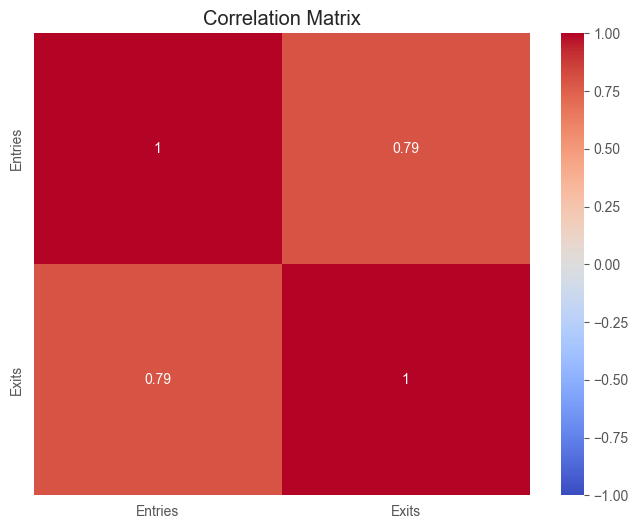

In [16]:
# Рассчитаем корреляционную матрицу
corr = mta[['Entries', 'Exits']].corr()

# Построим тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Преобразование категориальных признаков в числовые
df_encoded = pd.get_dummies(df, columns=['C/A', 'Unit', 'SCP', 'Station', 'Date', 'Time', 'Description', 'turnstile'])

# Определим числовые признаки и нормализуем их
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

# Применим PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Создание DataFrame с главными компонентами
pca_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])

# Объединим исходный DataFrame с главными компонентами
final_df = pd.concat([pca_df, df[['Entries', 'Exits']]], axis=1)

# Построим график объясненной дисперсии
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance by Principal Components')
plt.show()

# Выводим важность признаков
features = df_encoded.columns
pca_components = pd.DataFrame(pca.components_, columns=features, index=['PC1', 'PC2'])
print(pca_components)

In [18]:
# Описание каждого атрибута
description = mta.describe(include='all')
description

,C/A,Unit,SCP,Station,Date,Time,Description,Entries,Exits,datetime,turnstile
count,10963251,10963251,10963251,10963251,10963251,10963251,10963251,1.096325e+07,1.096325e+07,10963251,10963251
unique,753,470,247,379,364,85295,2,NaN,NaN,NaN,5107
top,PTH22,R549,00-00-00,34 ST-PENN STA,2022-11-06,00:00:00,REGULAR,NaN,NaN,NaN,E014-R374-00-05-01
freq,92106,146571,1010669,221623,32580,852802,10905897,NaN,NaN,NaN,2339
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.230180e+07,3.387026e+07,2022-07-02 02:13:41.032808960,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,2022-01-01 00:00:00,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.530450e+05,1.391400e+05,2022-04-02 08:00:00,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333050e+06,8.966160e+05,2022-07-02 01:53:10,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.932506e+06,3.940226e+06,2022-10-01 00:00:00,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.147338e+09,2.147414e+09,2022-12-30 23:59:31,NaN


In [19]:
# Информация о количестве пустых значений для каждого атрибута
missing_values = mta.isnull().sum()
missing_values

C/A            0
Unit           0
SCP            0
Station        0
Date           0
Time           0
Description    0
Entries        0
Exits          0
datetime       0
turnstile      0
dtype: int64

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, kstest

# Функция для графического и статистического анализа плотности распределения
def plot_density(df, column):
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Density plot for {column}')
    plt.show()
    sns.boxplot(x=df[column].dropna())
    plt.title(f'Box plot for {column}')
    plt.show()
    print(df[column].describe())


In [23]:
# Функция для графического и статистического анализа нормальности распределения данных
def plot_normality(df, column):
    # Q-Q plot
    from scipy.stats import probplot
    probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q plot for {column}')
    plt.show()
    
    # Шапиро-Уилка тест
    stat, p = shapiro(df[column].dropna())
    print(f'Shapiro-Wilk Test for {column}: Statistics={stat}, p-value={p}')
    
    # Д'Агостино тест
    stat, p = normaltest(df[column].dropna())
    print(f'D\'Agostino Test for {column}: Statistics={stat}, p-value={p}')
    
    # Критерий Колмогорова-Смирнова
    stat, p = kstest(df[column].dropna(), 'norm')
    print(f'Kolmogorov-Smirnov Test for {column}: Statistics={stat}, p-value={p}')
    
    if p > 0.05:
        print(f'{column} seems to follow a normal distribution (fail to reject H0)')
    else:
        print(f'{column} does not follow a normal distribution (reject H0)')

Attribute: Entries


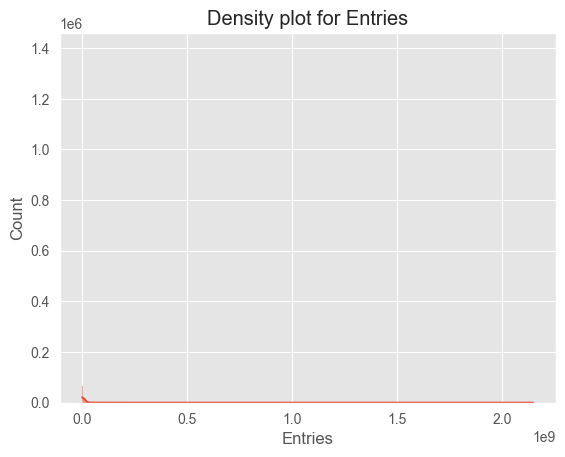

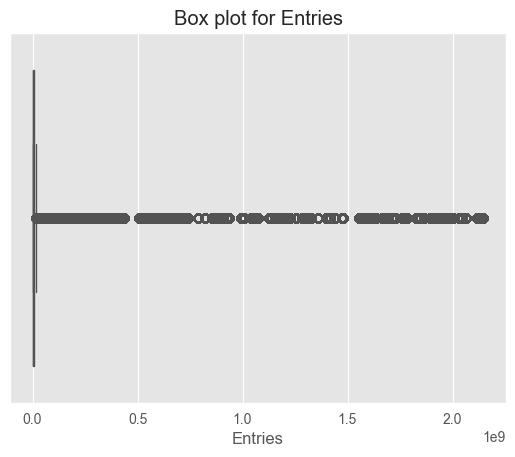

count    1.096325e+07
mean     4.230180e+07
std      2.218141e+08
min      0.000000e+00
25%      2.530450e+05
50%      1.333050e+06
75%      5.932506e+06
max      2.147338e+09
Name: Entries, dtype: float64


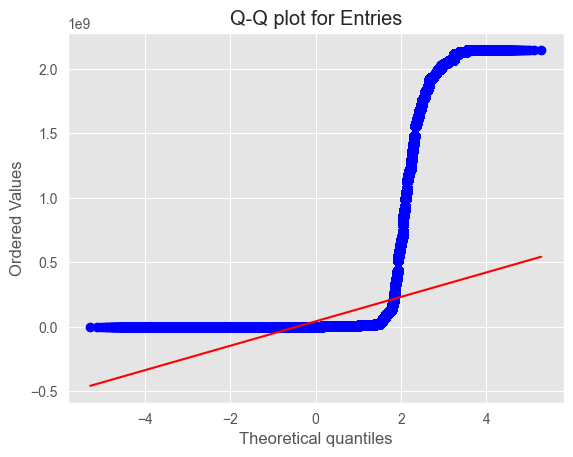

Shapiro-Wilk Test for Entries: Statistics=0.18234870709094542, p-value=2.500230739832349e-239
D'Agostino Test for Entries: Statistics=13255149.524662688, p-value=0.0
Kolmogorov-Smirnov Test for Entries: Statistics=0.9762278295967896, p-value=0.0
Entries does not follow a normal distribution (reject H0)
Attribute: Exits


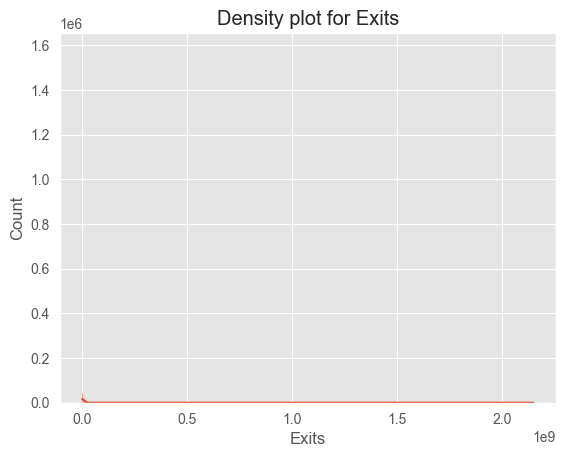

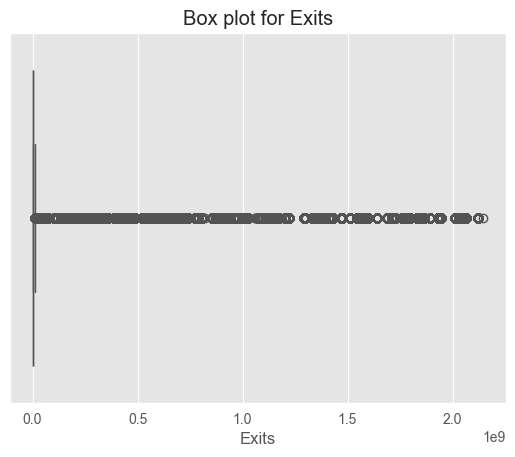

count    1.096325e+07
mean     3.387026e+07
std      1.949536e+08
min      0.000000e+00
25%      1.391400e+05
50%      8.966160e+05
75%      3.940226e+06
max      2.147414e+09
Name: Exits, dtype: float64


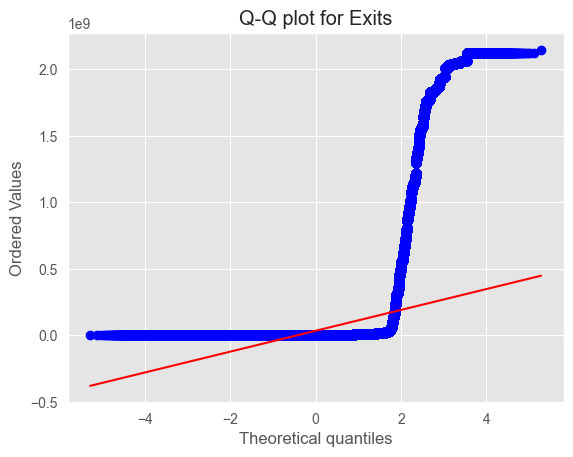

Shapiro-Wilk Test for Exits: Statistics=0.16176624194645095, p-value=2.53097565067555e-240
D'Agostino Test for Exits: Statistics=14052786.518398397, p-value=0.0
Kolmogorov-Smirnov Test for Exits: Statistics=0.9578285474104626, p-value=0.0
Exits does not follow a normal distribution (reject H0)


In [24]:
# Применение функций к каждому числовому атрибуту
numeric_columns = mta.select_dtypes(include=[np.number]).columns

for column in numeric_columns:
    print(f'Attribute: {column}')
    plot_density(mta, column)
    plot_normality(mta, column)